In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def simulate_trading_dynamics(a, b, h, rB, rI, p, psi, dt, T, kappa_alpha, kappa_xi, sigma_alpha, sigma_xi, seed):
    """
    Simulate the two‐player trading model (backward‐forward RK4 + OU noise),
    then plot:
      1) Inventories & price impact,
      2) Optimal trading speeds,
      3) Alpha over time.

    Returns
    -------
    df_ell : pd.DataFrame  # ℓ_closed(t)
    df_X   : pd.DataFrame  # X_t = [Q_B, Q_I, Y_imp]
    df_Y   : pd.DataFrame  # controls = [ν*(t), η*(t)]
    times  : np.ndarray    # time grid
    """
    # --- unpack parameters
    phi= 1 - h/2; psi= state["psi"]
    if seed is not None:
        np.random.seed(seed)

    # Define matrices A, B, A_hat, B_hat, G
    A = np.array([[0, 0, 0],
                  [0, 0, 0],
                  [0, 0, -p]])
    B = np.array([[1, -1, 0],
                  [0,  1, 0],
                  [h,  0, 0]])
    A_hat = np.array([[ (2*rB + p*h)/(2*a),  0,       p/(2*a)],
                      [0,                    rI/b,   p/(2*b)],
                      [-1,                   0,       0      ]])
    B_hat = np.array([[0,      -h/(2*a),  -p**2*h/(2*a)],
                      [-h/(2*b), 0,       0           ],
                      [0,        0,       p           ]])
    G = np.diag([-phi/a, -psi/b, 0])

    # Build the 6x6 matrix M
    top = np.hstack([A, B])
    bottom = np.hstack([A_hat, B_hat])
    M = np.vstack([top, bottom])

    # Initial condition for the backward-in-time integration (tau=0 corresponds to t=T)
    H0 = np.vstack([np.eye(3), G])
    #print(H0)


    # Integrate dH/dtau = -M @ H from tau=0 to tau=1 using RK4
    dt = 0.0001
    num_steps = int(1 / dt)
    H_list = [H0.copy()]

    # RK4 integration forward in tau
    H = H0.copy()
    for _ in range(num_steps):
        k1 = -M @ H
        k2 = -M @ (H + 0.5 * dt * k1)
        k3 = -M @ (H + 0.5 * dt * k2)
        k4 = -M @ (H + dt * k3)
        H = H + dt * (k1 + 2*k2 + 2*k3 + k4) / 6
        H_list.append(H.copy())

    # Now H_list[i] contains H evaluated at tau = i*dt, from i = 0 to 10, we can aslo see that
    #print(H_list)

    #Flip the order of H_list so we are going forward in time
    H_list = H_list[::-1]
    #print(H_list)

    R = []
    T = []

    #Extract the first three rows for R and last three row for T
    for i in range(len(H_list)):
        R.append(H_list[i][:3,:])
        T.append(H_list[i][3:,:])
        i = i+1


    #for i in range(len(R)):
        # this one you already had:
        #print(np.array_equal(R[i], H_list[i][:3, :]))

    #for i in range(len(T)):
        # compare T[i] to the bottom 3 rows, not the top
        #print(np.array_equal(T[i], H_list[i][3:, :]))


    #P_t is the matrix multi. of T and R^-1
    P_t = []
    for i in range(len(R)):
        P_t.append(T[i] @ np.linalg.inv(R[i]))
    #print(P_t)


    g_tB = []
    g_tI = []
    g_tY = []
    h_tB = []
    h_tI = []
    h_tY = []
    f_tB = []
    f_tI = []
    f_tY = []

    for i in range(len(P_t)):
        g_tB.append(P_t[i][0,0])
        g_tI.append(P_t[i][0,1])
        g_tY.append(P_t[i][0,2])
        h_tB.append(P_t[i][1,0])
        h_tI.append(P_t[i][1,1])
        h_tY.append(P_t[i][1,2])
        f_tB.append(P_t[i][2,0])
        f_tI.append(P_t[i][2,1])
        f_tY.append(P_t[i][2,2])
        i = i+1
    #print(g_tB,g_tI,g_tY,h_tB,h_tI,h_tY,f_tB,f_tI,f_tY)


    # your constants
    kappa_alpha = 5.0
    kappa_xi    = 15.0
    # a, b, h, etc. already defined

    # suppose g_tB, g_tI, g_tY, h_tB, ... f_tY are all lists of the same length N
    N = len(g_tB)

    # container for all the M-matrices
    M_list = []

    for i in range(N):
        # fetch the i-th coefficients
        gB, gI, gY = g_tB[i], g_tI[i], g_tY[i]
        hB, hI, hY = h_tB[i], h_tI[i], h_tY[i]
        fB, fI, fY = f_tB[i], f_tI[i], f_tY[i]

        M = np.zeros((6,6))

        # row 0 (g1‐equation)
        M[0,0] = kappa_alpha - gB       - gY*h
        M[0,2] =      gB -   gI         - h/(2*a)

        # row 1 (g2‐equation)
        M[1,1] = kappa_xi    - gB       - gY*h
        M[1,3] =      gB -   gI         - h/(2*a)

        # row 2 (h1‐equation)
        M[2,0] = - (hB + hY*h + h/(2*b))
        M[2,2] =    hB -   hI   + kappa_alpha

        # row 3 (h2‐equation)
        M[3,1] = - (hB + hY*h + h/(2*b))
        M[3,3] =    hB -   hI   + kappa_xi

        # row 4 (f1‐equation)
        M[4,0] = - (fB + fY*h)
        M[4,2] =      fB -   fI
        M[4,4] =    kappa_alpha

        # row 5 (f2‐equation)
        M[5,1] = - (fB + fY*h)
        M[5,3] =      fB -   fI
        M[5,5] =    kappa_xi

        M_list.append(M)

    # now M_list[i] is your 6×6 matrix at step i
    #print(M_list)


    # assume a, b, h are defined, and g_tB, h_tB, f_tB are lists of length N
    N = len(g_tB)

    C_list = []
    for i in range(N):
        C = np.array([
            -1/(2*a),
            g_tB[i] - h/(2*a),
            -1/(2*b),
            h_tB[i],
            0.0,
            f_tB[i],
        ]).reshape(6,1)    # <<< force it to be a (6,1) array
        C_list.append(C)
    # now C_list[i] is the 6×1 C-vector at time step i
    #print(C_list[0])


    l_tau = np.zeros((6,1))
    #print(l_tau)
    l_tau_list = [l_tau.copy()]

    # RK4 integration forward in tau
    l_t = l_tau.copy()
    #print(l_t)
    for i in range(num_steps):
        k1 = -M_list[i] @ l_t - C_list[i]
        k2 = -M_list[i] @ (l_t + 0.5 * dt * k1) - C_list[i]
        k3 = -M_list[i] @ (l_t + 0.5 * dt * k2) - C_list[i]
        k4 = -M_list[i] @ (l_t + dt * k3) - C_list[i]
        l_t = l_t + dt * (k1 + 2*k2 + 2*k3 + k4) / 6
        l_tau_list.append(l_t.copy())
        i = i+1

    # Now l_tau_list[i] contains l evaluated at tau = i*dt, from i = 0 to 10, we can aslo see that
    #print(l_tau_list)
    l_t_list = l_tau_list[::-1]
    #print(l_t_list)


    N = len(l_t_list)  # number of time points
    kappa_alpha, sigma_alpha = 5.0, 1.0
    kappa_xi,    sigma_xi    = 15.0, 100.0


    # 1. Simulate OU processes alpha and xi via Euler–Maruyama; initialise at zero imples ell[0] = 0
    alpha = np.zeros(N)
    xi    = np.zeros(N)
    for i in range(N-1):
        alpha[i+1] = alpha[i] - kappa_alpha*alpha[i]*dt + sigma_alpha * np.sqrt(dt) * np.random.randn()
        xi[i+1]    = xi[i]    - kappa_xi   *xi[i]*dt + sigma_xi    * np.sqrt(dt) * np.random.randn()

    # 2. Extract coefficient lists from l_t_list
    g1 = np.array([l[0,0] for l in l_t_list])
    g2 = np.array([l[1,0] for l in l_t_list])
    h1 = np.array([l[2,0] for l in l_t_list])
    h2 = np.array([l[3,0] for l in l_t_list])
    f1 = np.array([l[4,0] for l in l_t_list])
    f2 = np.array([l[5,0] for l in l_t_list])

    # 3. Compute closed‐form ℓ_cl(t) via equation (5.1)
    #    ℓ1 = g1*alpha + g2*xi,  ℓ2 = h1*alpha + h2*xi,  ℓ3 = f1*alpha + f2*xi
    ell_closed = np.vstack([
        g1 * alpha + g2 * xi,
        h1 * alpha + h2 * xi,
        f1 * alpha + f2 * xi
    ]).T  # shape (N, 3)

    # 4. Display results in a table for comparison
    df = pd.DataFrame(
        ell_closed,
        columns=["ℓ₁(t)", "ℓ₂(t)", "ℓ₃(t)"],
        index=np.linspace(0, 1, N)
    )

    #print(ell_closed)
    #print(ell_closed[1][0])


    N  = len(P_t)
    qB0, qI0, Y0 = 0.0, 0.0, 0.0  # initial inventories and impact

    # 1) Solve forward ODE for X_t via RK4
    X_list = []
    X = np.array([qB0, qI0, Y0])
    X_list.append(X.copy())

    for i in range(N - 1):
        P   = P_t[i]
        ell = ell_closed[i].flatten()[:3]  # use only the first 3 of ℓ = (g1,g2,...) -> here g, h, f pieces for coupling
        A_eff = A + B @ P
        def f(X_vec, idx=i):
            b_t = np.array([-xi[idx], 0.0, 0.0])
            return A_eff @ X_vec + B @ ell + b_t

        k1 = f(X)
        k2 = f(X + 0.5 * dt * k1)
        k3 = f(X + 0.5 * dt * k2)
        k4 = f(X +     dt * k3)
        X = X + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
        X_list.append(X.copy())

    # 2) Reconstruct Y_t = ℓ_t + P_t X_t
    Y_list = []
    for i in range(N):
        ell_full = ell_closed[i].flatten()    # full 6×1 ℓ = [g1, g2, h1, h2, f1, f2]
        # Controls are the first two components of Y: ν*, η* = first two of ℓ + P@X
        Y_vec = ell_full[:2] + (P_t[i] @ X_list[i])[:2]
        Y_list.append(Y_vec)

    # 3) Display results
    times = np.linspace(0, 1, N)
    df_X = pd.DataFrame(X_list, columns=["Q_B","Q_I","Y_imp"], index=times)
    df_Y = pd.DataFrame(Y_list, columns=["ν*","η*"], index=times)

    #print(df_X)
    #print(df_Y)


    # Build time grid
    N = len(X_list)
    times = np.linspace(0, 1, N)

    # Extract state trajectories
    Q_B = np.array([X[0] for X in X_list])
    Q_I = np.array([X[1] for X in X_list])
    Y_imp = np.array([X[2] for X in X_list])

    # Plot inventories and impact
    plt.figure()
    plt.plot(times, Q_B, color='red',   label='Q_B')   # Q_B in red
    plt.plot(times, Q_I, color='blue',  label='Q_I')   # Q_I in blue
    plt.plot(times, Y_imp, color='green', label='Y_imp')  # Y_imp in green (or pick another colour)
    plt.legend()
    plt.xlabel("t")
    plt.ylabel("Value")
    plt.title("Inventories and Price Impact Over Time")
    plt.show()

    # Extract control trajectories
    nu_star  = np.array([Y[0] for Y in Y_list])
    eta_star = np.array([Y[1] for Y in Y_list])

    # Plot controls
    plt.figure()
    plt.plot(times, nu_star, color='red',  label='ν*(t)')  # ν* in red
    plt.plot(times, eta_star, color='blue', label='η*(t)')  # η* in blue
    plt.legend()
    plt.xlabel("t")
    plt.ylabel("Trading Speed")
    plt.title("Optimal Trading Speeds Over Time")
    plt.show()

    #Plot Alpha
    plt.figure()
    plt.plot(times, alpha)
    plt.legend(["Alpha"])
    plt.xlabel("t")
    plt.ylabel("Value")
    plt.title("Alpha Over Time")
    plt.show()

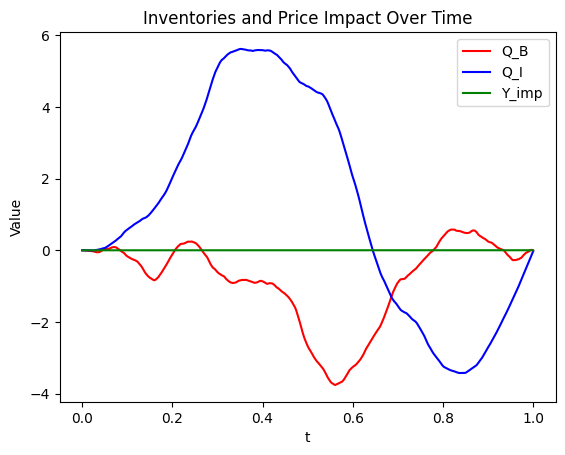

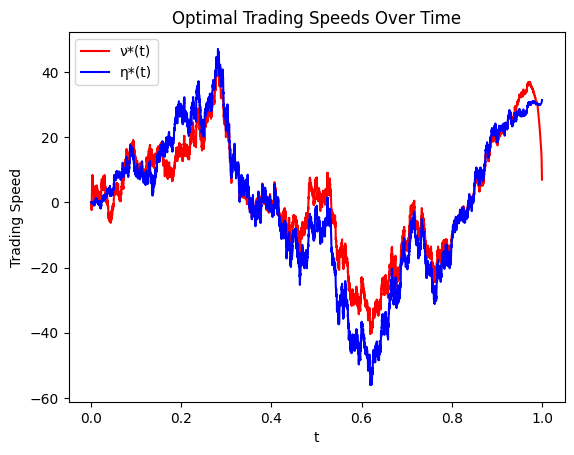

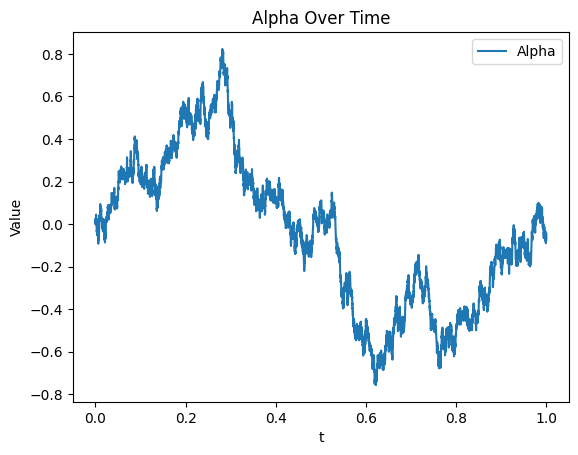

In [21]:
simulate_trading_dynamics(a=1.2e-3, b=1e-3, h=1e-3,
      rB=0,     rI=0,    p=16,
      psi=1,
      dt=1e-4,  T=1.0,
      kappa_alpha=5.0, kappa_xi=15.0,
      sigma_alpha=1.0, sigma_xi=100.0,
      seed=43)